# An analysis of the Gadget HDF5 initial condition test

Begin with the usual imports

In [1]:
import os
import copy
import yaml
import time
import pyEXP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from os.path import exists

plt.rcParams['figure.figsize'] = [12, 9]

### Switch to the working directory
I like to be explicit about my working directory but you don't need to do this here.  It would be sufficient to simply pass the full path to the coefficient factory below.

In [2]:
os.chdir('/media/weinberg/Simulation data/Nbody/Sphere/RunG')

### Configure the basis

In [3]:
# Get the basis config
#
halo_config = """
id          : sphereSL
parameters  :
  numr      : 1000
  rmin      : 0.000011
  rmax      : 1.99
  Lmax      : 6
  nmax      : 18
  rs        : 0.05
  modelname : mw_halo.model
"""


# Construct the basis instance
#
halo_basis = pyEXP.basis.Basis.factory(halo_config)

---- SLGridSph::read_cached_table: trying to read cached table . . .
---- SLGridSph::read_cached_table: Success!!


### Read the coefficients
This is a HDF5 file previously computed using the `make_coefficients_MPI.py` script.  You simply need to point `coeffile` at some coefficient file.

In [4]:
coeffile = 'RunG_halo_test.h5' # My test set...
coefs = pyEXP.coefs.Coefs.factory(coeffile)

### Check by making some surface renderings
Uses the final time slice but you could easily loop through all of them to make a movie, etc.

The coefficient time list is {} slices in [{}, {}] 566 0.0 19.16799998
Creating surfaces with times: [19.16799998]
Created fields instance
Created surfaces
We now have the following [time field] pairs
----------------------------------------
 19.1680  d
 19.1680  d0
 19.1680  d1
 19.1680  dd
 19.1680  fp
 19.1680  fr
 19.1680  ft
 19.1680  p
 19.1680  p0
 19.1680  p1


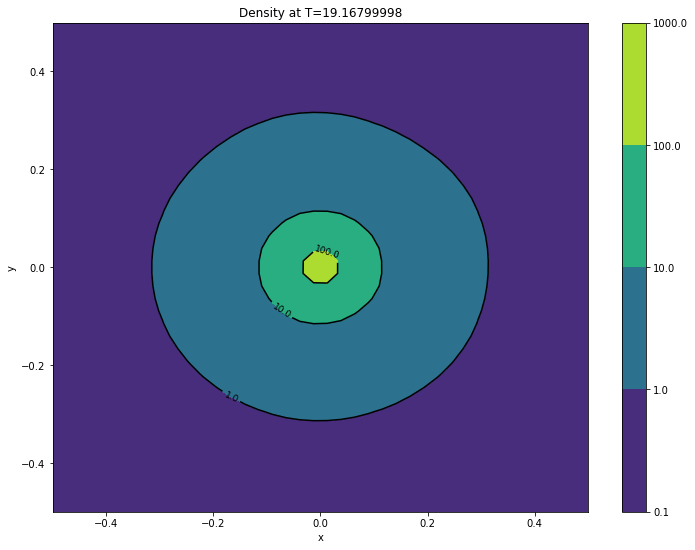

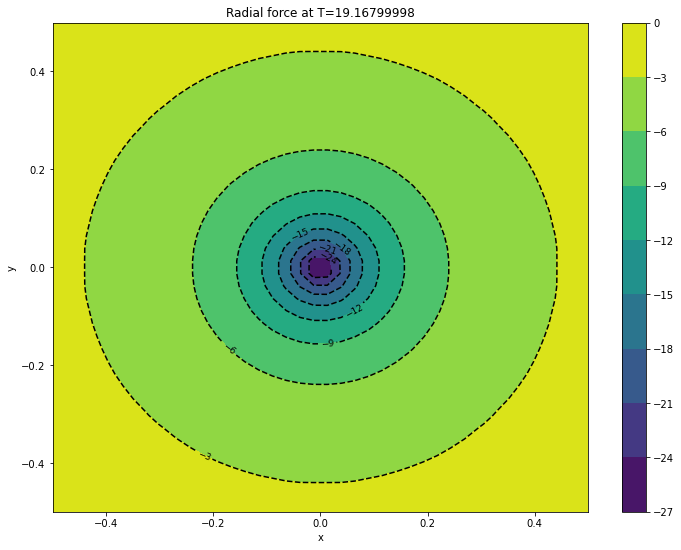

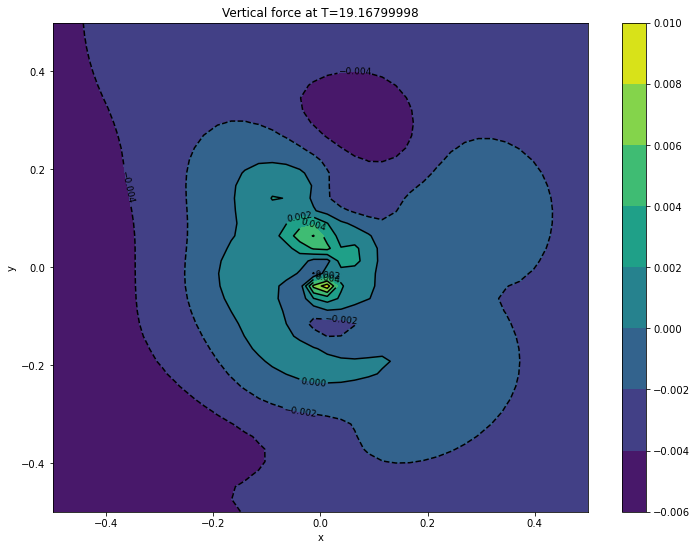

In [5]:
# Make the coefficients by the factory method
#

print('The coefficient time list is {} slices in [{}, {}]', len(coefs.Times()), coefs.Times()[0], coefs.Times()[-1])
#
times = coefs.Times()[-1:]
pmin  = [-0.5, -0.5, 0.0]
pmax  = [ 0.5,  0.5, 0.0]
grid  = [  40,   40,   0]

print('Creating surfaces with times:', times)

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

print('Created fields instance')

surfaces = fields.slices(halo_basis, coefs)

print('Created surfaces')

print("We now have the following [time field] pairs")
final = 0.0
for v in surfaces:
    print('-'*40)
    for u in surfaces[v]:
        print("{:8.4f}  {}".format(v, u))
        final = v

# Print the potential image at the final time
# 
nx = surfaces[final]['d'].shape[0]
ny = surfaces[final]['d'].shape[1]

x = np.linspace(pmin[0], pmax[0], nx)
y = np.linspace(pmin[1], pmax[1], ny)
xv, yv = np.meshgrid(x, y)

cont1 = plt.contour(xv, yv, surfaces[final]['d'].transpose(), colors='k', locator=ticker.LogLocator())
# cont1 = plt.contour(xv, yv, surfaces[final]['d'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['d'].transpose(), locator=ticker.LogLocator())
# cont2 = plt.contourf(xv, yv, surfaces[final]['d'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Density at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['fr'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['fr'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Radial force at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['ft'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['ft'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vertical force at T={}'.format(final))
plt.show()

### Test the basis field evaluator
First, we need to provide a coefficient set to the basis.  Then we use `getFields` to evaluate along the x axis and plot.

In [6]:
# Set the coefficients to the last time in the container
cof = coefs.getCoefStruct(coefs.Times()[-1])
halo_basis.set_coefs(cof)

# Evaluate the fields along the x axis
x = np.arange(-1, 1, 0.01)
fields = []
for i in range(len(x)):
    fields.append(halo_basis.getFields(x[i], 0.0, 0.0))
data = np.array(fields)

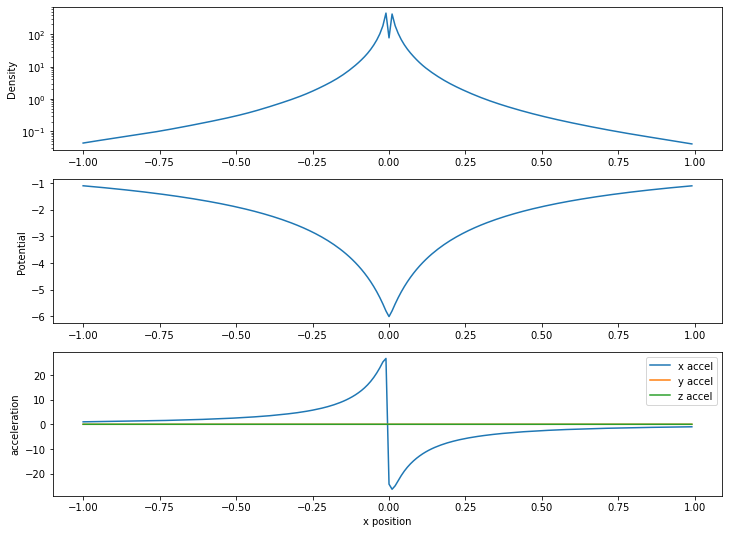

In [7]:
fig, ax = plt.subplots(3, 1)

ax[0].semilogy(x, data[:,0]+data[:,2])
ax[0].set_ylabel('Density')

ax[1].plot(x, data[:,1]+data[:,3])
ax[1].set_ylabel('Potential')

ax[2].plot(x, data[:,4], label='x accel')
ax[2].plot(x, data[:,5], label='y accel')
ax[2].plot(x, data[:,6], label='z accel')
ax[2].legend()
ax[2].set_xlabel('x position')
ax[2].set_ylabel('acceleration')

plt.show()

### Plot some of the coefficients
Make two panels: one with the l=m=0 coefficients and one with some l>1 coefficients.

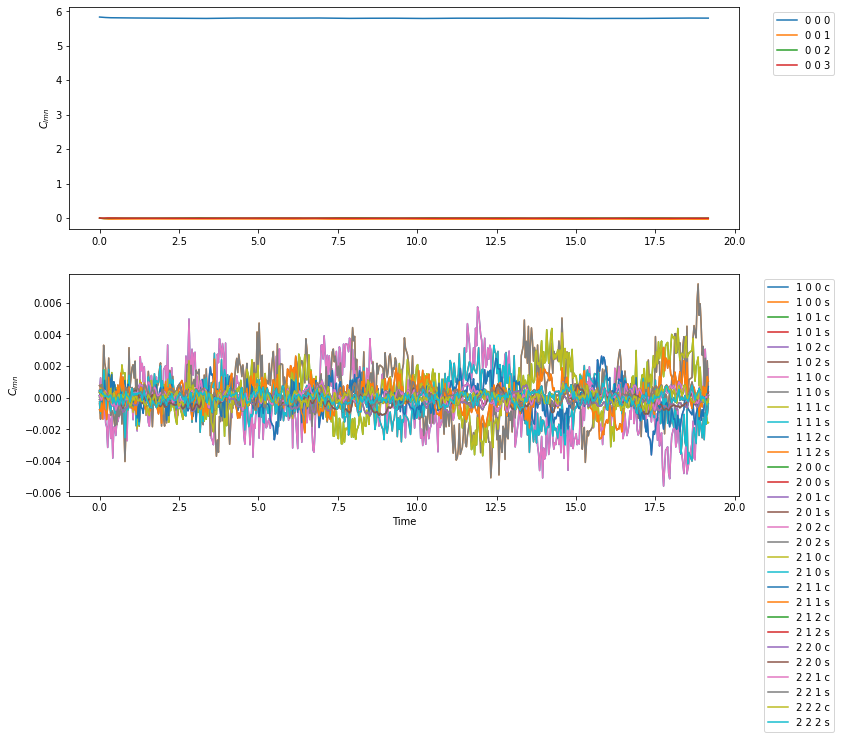

In [8]:
times = coefs.Times()
data  = coefs.getAllCoefs()

def I(l, m):
    return int(l*(l+1)/2) + 1

fig, ax = plt.subplots(2, 1)

for n in range(0, 4):
    ax[0].plot(times, np.real(data[0, n, :]), label='{} {} {}'.format(0, 0, n))
ax[0].set_ylabel(r'$C_{lmn}$')
ax[0].legend(bbox_to_anchor=(1.15, 1.0))

for l in range(1, 3):
    for m in range(0, l+1):
        for n in range(0, 3):
            ax[1].plot(times, np.real(data[I(l, m), n, :]), label='{} {} {} c'.format(l, m, n))
            ax[1].plot(times, np.imag(data[I(l, m), n, :]), label='{} {} {} s'.format(l, m, n))
ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$C_{lmn}$')
ax[1].legend(bbox_to_anchor=(1.15, 1.0))

plt.show()

### Plot the power
The the run of gravitational power with for each harmonic $l$ is returned in a array using the `Power()` member of `Coefs`.   These can be simply plotting using the `Times()` array as follows:

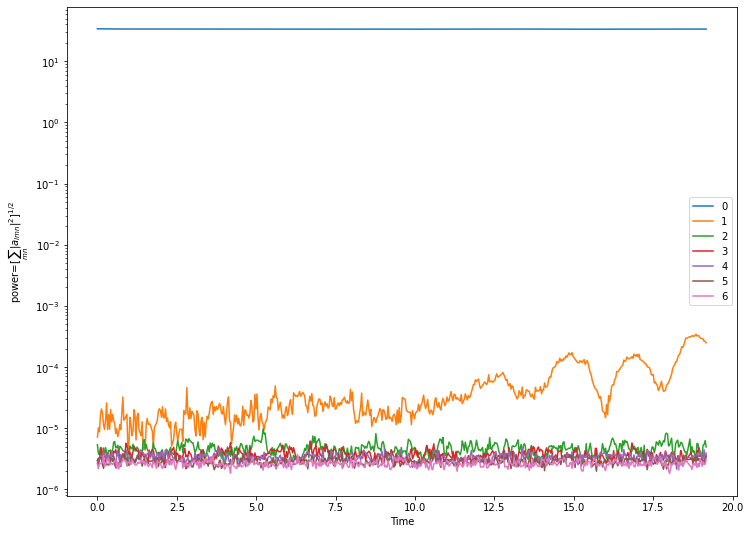

In [9]:
power = coefs.Power()
for i in range(0, power.shape[1]):
    plt.semilogy(coefs.Times(), power[:,i], label='{}'.format(i))
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'power=$[\sum_{mn}|a_{lmn}|^2]^{1/2}$')
plt.show()

### Let's apply MSSA to this coefficient set
We know from experience and the power plot above, that $l=1$ is key.  So lets start by examining the $l=1$ subspace.

In [10]:
# Make some custom [l, m, n] pairs
keylst = [[1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 0, 3], [1, 1, 0], [1, 1, 1], [1, 1, 2], [1, 1, 3]]
print("Custom keys=", keylst)

config = {coefs.getName(): (coefs, keylst, [])}

window = int(len(coefs.Times())/2)
npc = 10

print("Window={} PC number={}".format(window, npc))

startTime = time.time()
ssa = pyEXP.mssa.expMSSA(config, window, npc)

ev = ssa.eigenvalues()
print('Computed eigenvalues in {:6.2f} seconds'.format(time.time() - startTime))

Custom keys= [[1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 0, 3], [1, 1, 0], [1, 1, 1], [1, 1, 2], [1, 1, 3]]
Window=283 PC number=10
Eigen is using 4 threads
Computed eigenvalues in   0.42 seconds
shape U = 3396 x 10


Make a plot of the eigenvalues

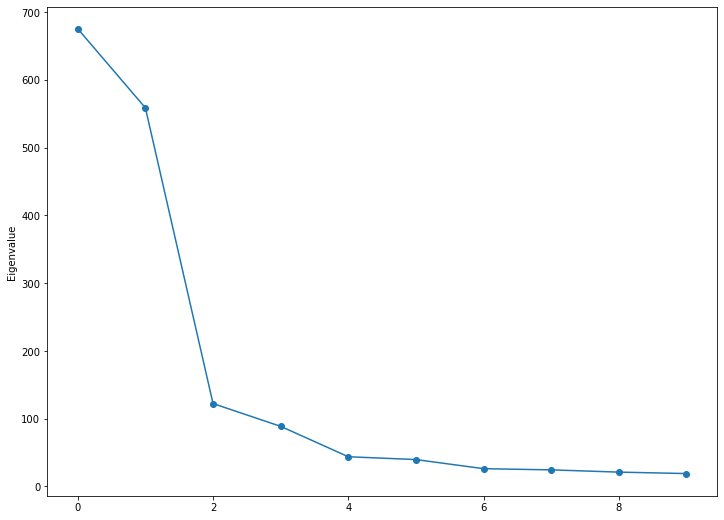

In [11]:
plt.plot(ev, '-o')
plt.ylabel('Eigenvalue')
plt.show()

The first 8 or so PCs look important perhaps.  Let's look:

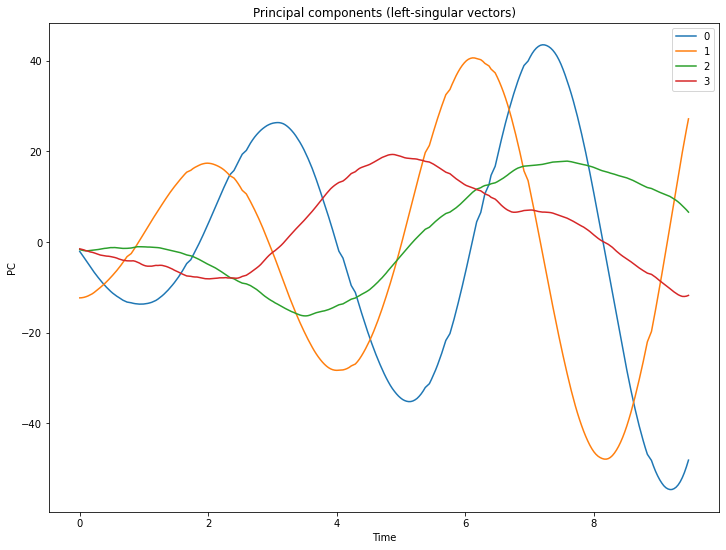

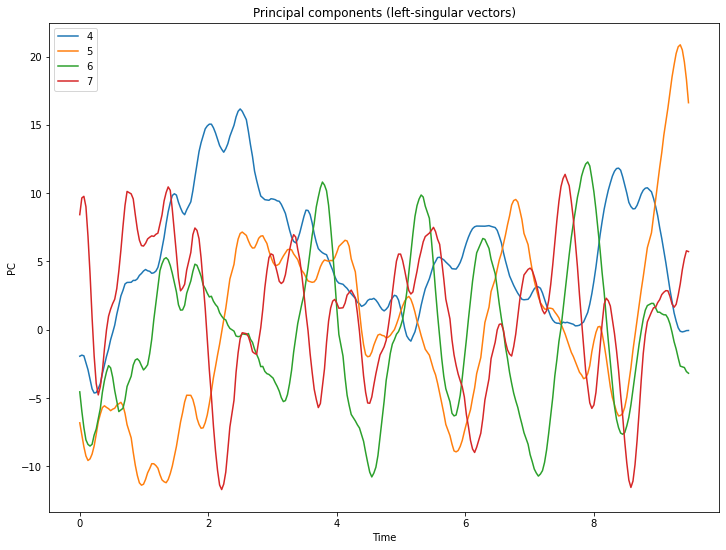

In [12]:
times = coefs.Times()
pc = ssa.getPC()

rows, cols = pc.shape

for i in range(min(cols,4)):
    plt.plot(times[0:rows], pc[:,i], '-', label="{:d}".format(i))

plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title("Principal components (left-singular vectors)")
plt.show()

for i in range(4, min(cols,8)):
    plt.plot(times[0:rows], pc[:,i], '-', label="{:d}".format(i))

plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title("Principal components (left-singular vectors)")
plt.show()


Let's look at the combination of PC 0 and 1

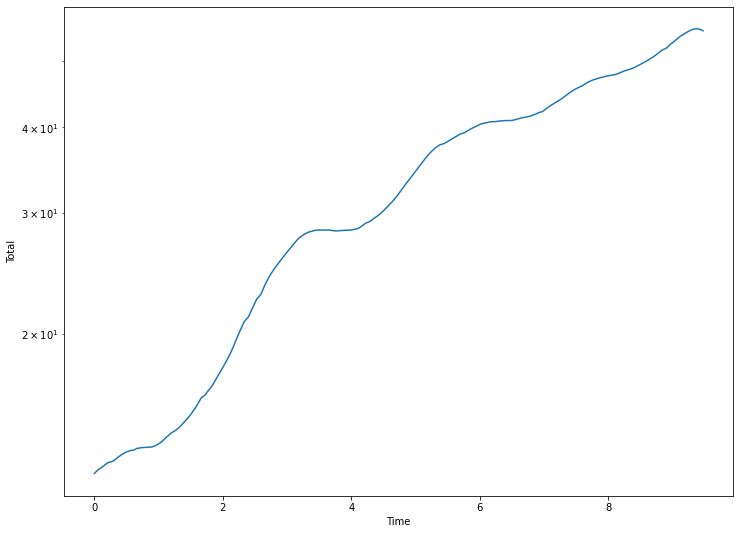

In [13]:
plt.semilogy(times[0:rows], np.sqrt(pc[:,0]**2 + pc[:,1]**2))
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()